In [37]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
%matplotlib inline

**Data loading**

In [38]:
# Load your data
heart_disease_data = pd.read_csv('heart.csv')

In [39]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [40]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


**Data formatting and cleaning**

*Renaming the columns with more meaningful names*

In [41]:
# Define a dictionary for renaming the columns
renaming_dict = {
    'age': 'age',
    'sex': 'gender',
    'cp': 'chest_pain_type',
    'trestbps': 'resting_blood_pressure',
    'chol': 'serum_cholesterol_mg_per_dl',
    'fbs': 'fasting_blood_sugar_gt_120_mg_per_dl',
    'restecg': 'resting_ecg_results',
    'thalach': 'maximum_heart_rate_achieved',
    'exang': 'exercise_induced_angina',
    'oldpeak': 'st_depression_induced_by_exercise_relative_to_rest',
    'slope': 'slope_of_peak_exercise_st_segment',
    'ca': 'number_of_major_vessels_colored_by_flourosopy',
    'thal': 'thalassemia',
    'target': 'diagnosis_of_heart_disease'
}

# Code to rename the columns
heart_disease_data_renamed = heart_disease_data.rename(columns=renaming_dict)

*Checking for missing values*

In [42]:
from sklearn.impute import KNNImputer

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Impute the missing values using K-Nearest Neighbors
heart_disease_data_imputed = pd.DataFrame(imputer.fit_transform(heart_disease_data_renamed),
                                          columns=heart_disease_data_renamed.columns)

# Check if there are any missing values left
missing_values_after_imputation = heart_disease_data_imputed.isnull().sum()

heart_disease_data_imputed.head(), missing_values_after_imputation


(    age  gender  chest_pain_type  resting_blood_pressure  \
 0  52.0     1.0              0.0                   125.0   
 1  53.0     1.0              0.0                   140.0   
 2  70.0     1.0              0.0                   145.0   
 3  61.0     1.0              0.0                   148.0   
 4  62.0     0.0              0.0                   138.0   
 
    serum_cholesterol_mg_per_dl  fasting_blood_sugar_gt_120_mg_per_dl  \
 0                        212.0                                   0.0   
 1                        203.0                                   1.0   
 2                        174.0                                   0.0   
 3                        203.0                                   0.0   
 4                        294.0                                   1.0   
 
    resting_ecg_results  maximum_heart_rate_achieved  exercise_induced_angina  \
 0                  1.0                        168.0                      0.0   
 1                  0.0       

## Preprocessing

In [43]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical and numerical columns
categorical_cols = heart_disease_data_imputed.select_dtypes(include=['object', 'category']).columns
numerical_cols = heart_disease_data_imputed.select_dtypes(include=['int64', 'float64']).columns

# Create a transformer for numerical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply transformations to the dataset
heart_disease_data_preprocessed = preprocessor.fit_transform(heart_disease_data_imputed)

## Modeling

In [44]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

target = heart_disease_data_imputed['diagnosis_of_heart_disease'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(heart_disease_data_preprocessed, target, test_size=0.3, random_state=20)

In [45]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    # Add other parameters here
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy


1.0

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [47]:
m1="Logistic Regression"
lr_model = LogisticRegression(solver="liblinear",random_state=2 )
# training the model with training data
lr_model.fit(X_train, y_train)
# Accuracy on training data
X_train_prediction = lr_model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction = lr_model.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_lr*100)

#Confussion matrix
LR_conf_matrix = confusion_matrix(y_test, X_test_prediction)
print("Confussion matrix")
print(LR_conf_matrix)

Accuracy on Training data:  100.0
Accuracy on Test data:  100.0
Confussion matrix
[[149   0]
 [  0 159]]


## Naive Bayes

In [48]:
m2="Naive Bayes"

nb = GaussianNB()
# training the model with training data
nb.fit(X_train,y_train)
# Accuracy on training data
X_train_prediction = nb.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction = nb.predict(X_test)
test_data_accuracy_nb = accuracy_score(X_test_prediction, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_nb*100)

#Confussion matrix
nb_conf_matrix = confusion_matrix(y_test, X_test_prediction)
print("Confussion matrix")
print(nb_conf_matrix)

Accuracy on Training data:  100.0
Accuracy on Test data:  100.0
Confussion matrix
[[149   0]
 [  0 159]]


## Random Forest

In [49]:
m3="Random Forest"
rf = RandomForestClassifier(n_estimators=100, criterion="entropy",max_depth=7, min_samples_leaf=2, max_features="sqrt",random_state=2)  
# training the model with training data
rf.fit(X_train,y_train)
# Accuracy on training data
X_train_prediction = rf.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)

# Accuracy on test data
X_test_prediction = rf.predict(X_test)
test_data_accuracy_rf = accuracy_score(X_test_prediction, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_rf*100)

#Confussion matrix
rf_conf_matrix = confusion_matrix(y_test, X_test_prediction)
print("Confussion matrix")
print(rf_conf_matrix)

Accuracy on Training data:  100.0
Accuracy on Test data:  100.0
Confussion matrix
[[149   0]
 [  0 159]]


## Gradient Boosting

In [50]:
m4="Extreme Gradient Boost"
Egb = GradientBoostingClassifier(n_estimators=100, subsample= 0.2, min_samples_leaf=2,max_depth=5,random_state=2,max_features="sqrt")
# training the model with training data
Egb.fit(X_train,y_train)
# Accuracy on training data
X_train_prediction = Egb.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_prediction = Egb.predict(X_test)
test_data_accuracy_egb = accuracy_score(X_test_prediction, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_egb*100)

#Confussion matrix
Egb_conf_matrix = confusion_matrix(y_test, X_test_prediction)
print("Confussion matrix")
print(Egb_conf_matrix)

Accuracy on Training data:  100.0
Accuracy on Test data:  100.0
Confussion matrix
[[149   0]
 [  0 159]]


## KNN

In [51]:
m5="K-Neighbour"
knn = KNeighborsClassifier(n_neighbors=20, algorithm="auto" )
# train on the training set
knn.fit(X_train, y_train)
# Accuracy on training data
X_train_predict= knn.predict(X_train)
training_data_accuracy=accuracy_score(X_train_predict, y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_predict= knn.predict(X_test)
test_data_accuracy_knn=accuracy_score(X_test_predict, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_knn*100)
#Confussion matrix
knn_confusion_matrix=  confusion_matrix(y_test,X_test_predict)
print("Confusion Matrix")
print(knn_confusion_matrix)

Accuracy on Training data:  96.51324965132495
Accuracy on Test data:  97.07792207792207
Confusion Matrix
[[146   3]
 [  6 153]]


## SVC

In [52]:
m6="svc"
svc = SVC(C=5,kernel="rbf")
svc.fit(X_train, y_train)
# Accuracy on training data
X_train_predict= svc.predict(X_train)
training_data_accuracy=accuracy_score(X_train_predict, y_train)
print(f"Accuracy on Training data: ",training_data_accuracy*100)
# Accuracy on test data
X_test_predict= svc.predict(X_test)
test_data_accuracy_svc=accuracy_score(X_test_predict, y_test)
print(f"Accuracy on Test data: ",test_data_accuracy_svc*100)
#Confussion matrix
knn_confusion_matrix =  confusion_matrix(y_test,X_test_predict)
print("Confusion Matrix")
print(knn_confusion_matrix)

Accuracy on Training data:  100.0
Accuracy on Test data:  100.0
Confusion Matrix
[[149   0]
 [  0 159]]


## Comparing the models

In [53]:
results = {"Models": [m1, m2, m3 ,m4, m5, m6],
           "Accuracy": [test_data_accuracy_lr, test_data_accuracy_nb, test_data_accuracy_rf,test_data_accuracy_egb, test_data_accuracy_knn, test_data_accuracy_svc]}
    
for (key, value) in results.items():
    if key=="Accuracy":
        results[key]=  [item*100 for item in results[key]]

    
result_df=pd.DataFrame(results)

In [54]:
result_df

,Models,Accuracy
0,Logistic Regression,100.000000
1,Naive Bayes,100.000000
2,Random Forest,100.000000
3,Extreme Gradient Boost,100.000000
4,K-Neighbour,97.077922
5,svc,100.000000


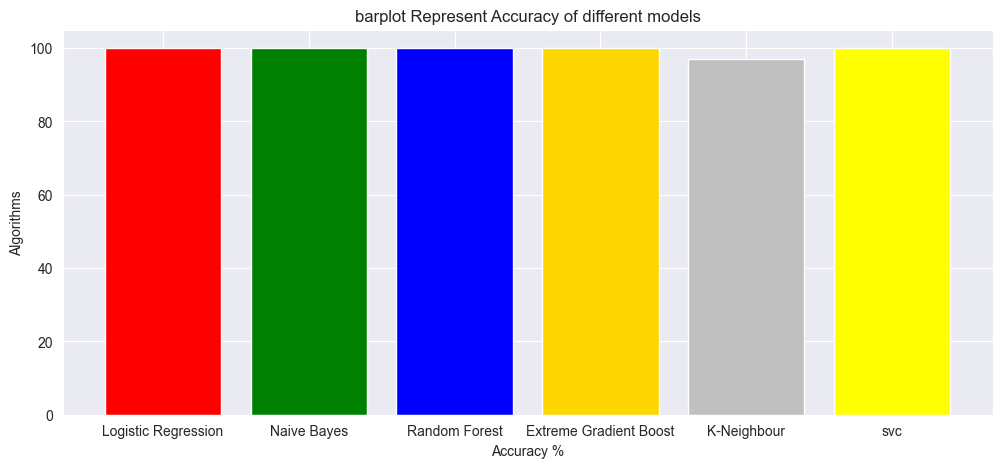

In [55]:
colors = ['red','green','blue','gold','silver','yellow']
plt.figure(figsize=(12,5))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(result_df['Models'],result_df['Accuracy'],color = colors)
plt.show()